Este es el script de código que entrena el modelo con __regresión lineal__ para predecir el __precio máximo__. El entrenamiento se ha realizado siguiendo varias <u>estrategias</u>:

- Modelo base sin escalar
    - Todo el conjunto
    - Entradas < 100€
    - Solo variables numéricas
> Como los precios altos estaban elevando mucho el precio, se cambia el conjunto a otro filtrado por entradas <= 100€.
- Modelo base con escalado de variables numéricas
    - bucle manual con StandardScaler()
    - bucle manual con RobustScaler()
    - pipeline con RobustScaler() en ColumnTransformer()
    - pipeline con RobustScaler() solo con variables numéricas
> Como los resultados con el escalado eran similares a los resultados sin escalar, las técnicas de búsqueda se han hecho sin escalar.
- Búsqueda de mejor combinación de parámetros con GridSearchCV
- Búsqueda de mejor combinación de parámetros con RandomizedSearchCV
> En regularización, sin embargo, se emplee un método u otro siempre hay que estandarizar o normalizar los predictores. Hecho con Robust Scaler pero también guardados los resultados con Standard Scaler.
- Regularización con Ridge buscando el mejor valor de alpha
    - Ridge sin escalar
    - Ridge escalando con RobustScaler()
- Regularización con Lasso buscando el mejor valor de alpha
- Regularización con Elastic Net buscando los mejores valores de lambda y alpha


Para todos ellos, se han calculado las <u>métricas</u>:
- MAPE (Mean Absolute Percentage Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)

Además, para todos ellos, se han calculado los <u>coeficientes</u> del modelo ajustado y mostrado en una gráfica.

Al final del script hay una <u>tabla resumen</u> que reúne todas las <u>métricas</u>, <u>tiempos de ejecución</u> y <u>otros valores importantes</u> para cada versión del algoritmo de regresión lineal.

## INSTALACIÓN DE LIBRERÍAS Y MLFLOW

In [ ]:
#!pip install mlflow

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import mlflow
#import mlflow.sklearn
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [3]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')

## LECTURA Y PREPROCESADO DE LOS DATOS

In [ ]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('maxEstratificado.parquet', '../drive')
# hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
datos = pd.read_parquet('datos/maxEstratificado.parquet') #

In [ ]:
# Configurar MLflow
mlflow.set_experiment("Linear Regression Max Price")

In [5]:

def cargar_modelo_mlflow(modelo, experimento, run_name, results, time):

    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("results.csv", index=False)

    # Iniciar un nuevo run de MLflow
    with mlflow.start_run(run_name=run_name):

        # Configurar el experimento de MLflow
        mlflow.set_experiment(experimento)

        #mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_params(modelo.get_params())
        mlflow.log_metric("execution_time", time)

        mlflow.sklearn.log_model(modelo, "model")

        # Registrar el archivo CSV en MLflow
        mlflow.log_artifact("results.csv", "results")

    mlflow.end_run()


In [6]:
import pandas as pd
datos= pd.read_parquet('maxEstratificado.parquet')
datos

,name,EventStartTime,SalesStartTIme,SalesEndTime,max_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
2,AC/DC - Power Up Tour,2024-12-14 20:00:00+00:00,2024-03-01 11:00:00+00:00,2024-12-14 20:00:00+00:00,300.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,288,0,1,0
3,AC/DC - Power Up Tour,2024-11-30 21:00:00+00:00,2024-03-01 11:00:00+00:00,2024-11-30 21:00:00+00:00,340.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,274,0,1,0
4,AC/DC - Power Up Tour,2024-05-29 19:30:00+00:00,2024-02-16 09:00:00+00:00,2024-05-29 19:30:00+00:00,360.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,103,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,40.0,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,0,1,0,0,0,176,0,1,3
490,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.0,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,0,102,0,1,3
491,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.0,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,0,291,0,1,3
492,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,75.0,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,0,266,0,1,3


In [ ]:
len(datos.columns)

67

In [ ]:
datos['fold']

0      0
1      0
2      0
3      0
4      0
      ..
489    3
490    3
491    3
492    3
493    3
Name: fold, Length: 494, dtype: int64

In [7]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados']

datos.drop(columnas, axis=1, inplace=True)

In [ ]:
datos

,max_price,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,28.0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,...,0,0,0,0,0,0,85,0,1,0
1,50.0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,...,0,0,0,0,0,0,85,0,1,0
2,300.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,288,0,1,0
3,340.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,274,0,1,0
4,360.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,103,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,40.0,0,4.564084e+06,60.904615,1.716398e+06,0,1,3,0,1.0,...,0,0,1,0,0,0,176,0,1,3
490,22.0,1,4.564084e+06,60.904615,1.716398e+06,0,1,8,0,1.0,...,0,0,0,0,0,0,102,0,1,3
491,35.0,0,4.564084e+06,60.904615,1.716398e+06,0,1,2,0,1.0,...,0,0,0,0,0,0,291,0,1,3
492,75.0,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,...,0,0,0,0,0,0,266,0,1,3


In [8]:
# las numéricas

columnas_a_escalar = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']


In [9]:
# División de los datos en X e y
# ==============================================================================
# RANDOM_STATE = 83 #fijamos la semilla que no hace falta en nuestro estudio

# y es la variable objetivo
# X = datos.iloc[:,1:]
X = datos.drop(columns=['max_price', 'fold'])
y = datos['max_price']

In [ ]:
print(X)
print(y)

     num_links  seguidoresSpotify  popularidad        subsYT  VenueClass  \
0            1       4.564084e+06    60.904615  1.716398e+06           2   
1            1       4.564084e+06    60.904615  1.716398e+06           2   
2           10       2.797956e+07    82.000000  1.716398e+06           3   
3           10       2.797956e+07    82.000000  1.716398e+06           3   
4           10       2.797956e+07    82.000000  1.716398e+06           3   
..         ...                ...          ...           ...         ...   
489          0       4.564084e+06    60.904615  1.716398e+06           0   
490          1       4.564084e+06    60.904615  1.716398e+06           0   
491          0       4.564084e+06    60.904615  1.716398e+06           0   
492          0       4.564084e+06    60.904615  1.716398e+06           1   
493          0       4.564084e+06    60.904615  1.716398e+06           2   

     NumGeneros  peso_promotor  tiene_lastfm_url  \
0             1             22     

### Uso de __cross_validate__ para hacer la validación cruzada:

Si bien __cross_val_score__ es la función por defecto para realizar la validación cruzada y devolver la métrica que se quiere calcular gracias al atributo cv_returns de esta función, en nuestro código, como no tenemos una sino 3 métricas, Python recomienda mejor el uso de __cross_validate__.

En la función cross_validate de scikit-learn, no existe un atributo llamado cv_returns para obtener las métricas directamente. Sin embargo, se puede acceder a las métricas calculadas durante la validación cruzada utilizando la salida de la función cross_validate. Esta salida es un diccionario que contiene varias claves, incluyendo las métricas calculadas para cada división de los datos de entrenamiento y prueba.

Por ejemplo, si se tiene configurado scoring para calcular el MAPE, MSE y RMSE, se puede acceder a estas métricas utilizando las claves test_mape, test_mse y test_rmse para el conjunto de prueba, y train_mape, train_mse y train_rmse para el conjunto de entrenamiento.

## MODELO BASE SIN ESCALAR

Tiempo de ejecución: 0.12637710571289062 segundos
MAPE scores por iteración (entrenamiento): [0.88492694 0.88843133 0.53801678 0.79197027]
MAPE scores por iteración (validación): [1.14765789 1.84680298 0.72313412 1.67401899]

MSE scores por iteración (entrenamiento): [7079.5949659  6216.07596685 2284.69611497 4976.63765232]
MSE scores por iteración (validación): [ 8221.75127653 13514.01122379 30548.87472058 66420.35469598]

RMSE scores por iteración (entrenamiento): [84.14032901 78.84209514 47.7984949  70.54528795]
RMSE scores por iteración (validación): [ 90.67387317 116.24977946 174.78236387 257.72146728]

Promedio de métricas (entrenamiento):
  MAPE: 0.775836328669608
  MSE: 5139.251175008919
  RMSE: 70.33155175257019

Promedio de métricas (validación):
  MAPE: 1.3479034932796192
  MSE: 29676.247979218464
  RMSE: 159.8568709453982


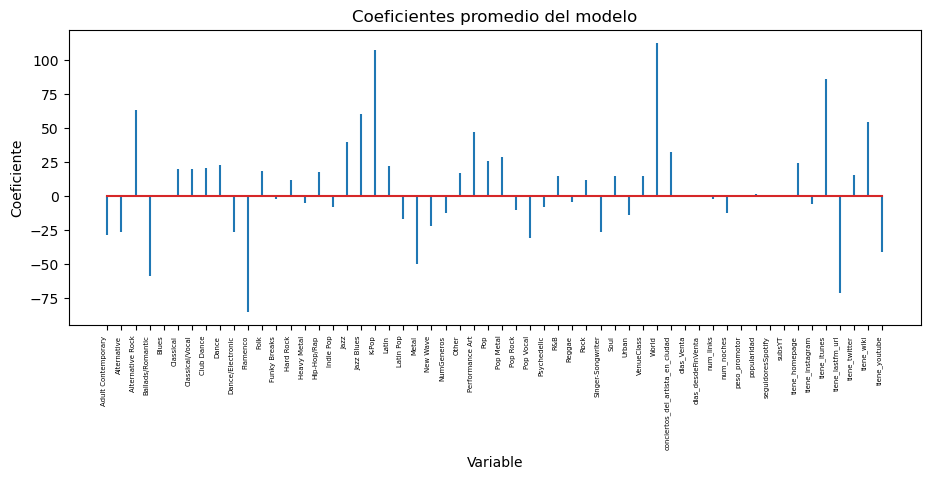

2024/06/10 19:10:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/06/10 19:10:17 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [10]:
import pandas as pd
from sklearn.model_selection import cross_validate, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

# Tiempo de inicio de la ejecución
start_time = time.time()

# Definir el modelo
modelo = LinearRegression()

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_validate(modelo, X, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Obtener los resultados de la validación cruzada para cada iteración
train_mape_scores = -scores['train_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
train_mse_scores = -scores['train_mse']
train_rmse_scores = -scores['train_rmse']

test_mape_scores = -scores['test_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
test_mse_scores = -scores['test_mse']
test_rmse_scores = -scores['test_rmse']

# Imprimir los resultados para cada iteración
print("MAPE scores por iteración (entrenamiento):", train_mape_scores)
print("MAPE scores por iteración (validación):", test_mape_scores)

print("\nMSE scores por iteración (entrenamiento):", train_mse_scores)
print("MSE scores por iteración (validación):", test_mse_scores)

print("\nRMSE scores por iteración (entrenamiento):", train_rmse_scores)
print("RMSE scores por iteración (validación):", test_rmse_scores)

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_mape_scores)
train_mse_mean = np.mean(train_mse_scores)
train_rmse_mean = np.mean(train_rmse_scores)

test_mape_mean = np.mean(test_mape_scores)
test_mse_mean = np.mean(test_mse_scores)
test_rmse_mean = np.mean(test_rmse_scores)

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

# Obtener los coeficientes del modelo entrenado en cada iteración
all_coefs = [pd.DataFrame({'predictor': X.columns, 'coef': est.coef_}) for est in scores['estimator']]

# Calcular los coeficientes promedio
average_coefs = pd.concat(all_coefs).groupby('predictor')['coef'].mean()

# Crear la gráfica de barras para los coeficientes promedio
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(average_coefs.index, average_coefs.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes promedio del modelo')
plt.show()

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base sin escalar todo el conjunto', scores, execution_time)


| Iteración | MAPE (entrenamiento) | MAPE (validación) | MSE (entrenamiento) | MSE (validación) | RMSE (entrenamiento) | RMSE (validación) |
|-----------|-----------------------|-------------------|----------------------|------------------|----------------------|-------------------|
| 1         | 0.884927              | 1.147658          | 7079.594966          | 8221.751278      | 84.140329            | 90.673873         |
| 2        | 0.888431              | 1.846803          | 6216.075967          | 13514.011224     | 78.842095            | 116.249779        |
| 3         | 0.538017              | 0.723134          | 2284.696115          | 30548.874721     | 47.798495            | 174.782364        |
| 4         | 0.791970              | 1.674019          | 4976.637652          | 66420.354698     | 70.545288            | 257.721467        |
| **Promedio** | **0.775836**          | **1.347903**      | **5139.251175**       | **29676.247980** | **70.331552**        | **159.856871**     |

**Tiempo de ejecución:** 0.06770539283752441 segundos


In [11]:
import plotly.express as px

# Obtener las predicciones y los valores verdaderos
predicciones = []
observados = []

for train_index, test_index in ps.split():
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    predicciones.extend(y_pred)
    observados.extend(y_test)

# Crear un DataFrame con los precios reales, predichos y el nombre del concierto (u otra categoría si aplica)
df = pd.DataFrame({'Precio Real': observados, 'Precio Predicho': predicciones})

# Crear un scatter plot interactivo con Plotly
fig = px.scatter(df, x='Precio Real', y='Precio Predicho',
                 title='Comparación de Precios Reales vs Precios Predichos (Regresión Lineal)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
              x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el scatter plot interactivo
fig.show()

Si hay un error tan grande puede deberse a la dispersión en los precios. Se ve que en los casos más raros (precio real más alto), hay una infraestimación muy grande y seguramente eso hace que el error empeore mucho... ¿Qué pasaría si calculáramos el error en entradas de menos de 100€?

Tiempo de ejecución: 0.08421158790588379 segundos
MAPE scores por iteración (entrenamiento): [0.22505313 0.22339005 0.23580764 0.25208765]
MAPE scores por iteración (validación): [0.48400239 0.52671701 0.32832155 0.47129094]

MSE scores por iteración (entrenamiento): [119.58934626 135.24522733 134.10928324 157.94377735]
MSE scores por iteración (validación): [535.550378   314.64024782 313.02940216 259.71875343]

RMSE scores por iteración (entrenamiento): [10.93569139 11.62949815 11.58055626 12.56756847]
RMSE scores por iteración (validación): [23.14196141 17.73810158 17.69263695 16.11579205]

Promedio de métricas (entrenamiento):
  MAPE: 0.23408461844199457
  MSE: 136.72190854653957
  RMSE: 11.678328570147627

Promedio de métricas (validación):
  MAPE: 0.45258297187931407
  MSE: 355.7346953515903
  RMSE: 18.67212299876351


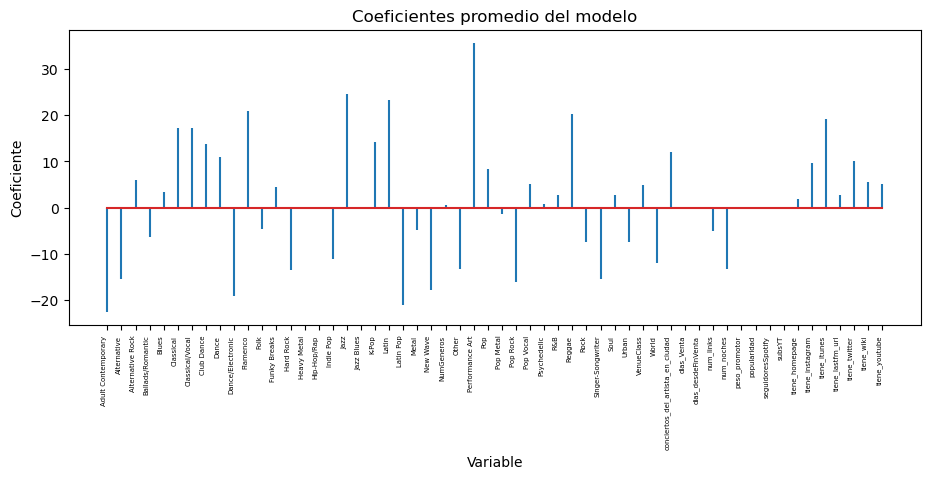

In [12]:
import pandas as pd
from sklearn.model_selection import cross_validate, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

# Filtrar los datos para obtener solo las filas con precios menores a 100€
filtered_indices = datos[y < 100].index
X_filtered = X.loc[filtered_indices]
y_filtered = y.loc[filtered_indices]
fold_filtered = datos.loc[filtered_indices, 'fold']

# Tiempo de inicio de la ejecución
start_time = time.time()

# Definir el modelo
modelo = LinearRegression()

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Definir el array test_fold a partir de la columna 'fold' del conjunto filtrado
test_fold = fold_filtered.values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_validate(modelo, X_filtered, y_filtered, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Obtener los resultados de la validación cruzada para cada iteración
train_mape_scores = -scores['train_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
train_mse_scores = -scores['train_mse']
train_rmse_scores = -scores['train_rmse']

test_mape_scores = -scores['test_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
test_mse_scores = -scores['test_mse']
test_rmse_scores = -scores['test_rmse']

# Imprimir los resultados para cada iteración
print("MAPE scores por iteración (entrenamiento):", train_mape_scores)
print("MAPE scores por iteración (validación):", test_mape_scores)

print("\nMSE scores por iteración (entrenamiento):", train_mse_scores)
print("MSE scores por iteración (validación):", test_mse_scores)

print("\nRMSE scores por iteración (entrenamiento):", train_rmse_scores)
print("RMSE scores por iteración (validación):", test_rmse_scores)

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_mape_scores)
train_mse_mean = np.mean(train_mse_scores)
train_rmse_mean = np.mean(train_rmse_scores)

test_mape_mean = np.mean(test_mape_scores)
test_mse_mean = np.mean(test_mse_scores)
test_rmse_mean = np.mean(test_rmse_scores)

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

# Obtener los coeficientes del modelo entrenado en cada iteración
all_coefs = [pd.DataFrame({'predictor': X_filtered.columns, 'coef': est.coef_}) for est in scores['estimator']]

# Calcular los coeficientes promedio
average_coefs = pd.concat(all_coefs).groupby('predictor')['coef'].mean()

# Crear la gráfica de barras para los coeficientes promedio
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(average_coefs.index, average_coefs.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes promedio del modelo')
plt.show()

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base entradas <100', scores, execution_time)

| **Iteración**  | **MAPE (Entrenamiento)** | **MAPE (Validación)** | **MSE (Entrenamiento)** | **MSE (Validación)** | **RMSE (Entrenamiento)** | **RMSE (Validación)** |
|-------------------------|--------------------------|-----------------------|-------------------------|----------------------|--------------------------|-----------------------|
| 1                | 0.22505313               | 0.48400239            | 119.58934626            | 535.55037793         | 10.93569139              | 23.14196141           |
| 2                | 0.22339005               | 0.52671701            | 135.24522733            | 314.64024782         | 11.62949815              | 17.73810158           |
| 3                | 0.23580764               | 0.32832155            | 134.10928324            | 313.02940218         | 11.58055626              | 17.69263695           |
| 4                | 0.25208765               | 0.47129094            | 157.94377735            | 259.71875343         | 12.56756847              | 16.11579205           |
| **Promedio**         | **0.2340846184403806**   | **0.45258297188237145** | **136.7219085465396** | **355.7346953407947** | **11.678328570147627**  |**18.672122998571112** |

**Tiempo de ejecución**: 0.0776517391204834 segundos


¡El error ha bajado a 18€! Por tanto, el modelo no es que no estuviera aprendiendo bien sino que es muy sensible a los valores atípicos que en este conjunto de datos hay unos cuantos (y eso que ya eliminamos otros aún más atípicos). Vamos a mostrar el scatter de este modelo filtrado:

In [13]:
# Obtener las predicciones de cada modelo entrenado en cada pliegue
y_pred = np.zeros_like(y_filtered)
for train_idx, test_idx in ps.split():
    modelo.fit(X_filtered.iloc[train_idx], y_filtered.iloc[train_idx])
    y_pred[test_idx] = modelo.predict(X_filtered.iloc[test_idx])

# Crear un DataFrame con los precios reales y predichos
df = pd.DataFrame({'Precio Real': y_filtered, 'Precio Predicho': y_pred})

# Crear un scatter plot interactivo con Plotly
fig = px.scatter(df, x='Precio Real', y='Precio Predicho', title='Comparación de Precios Reales vs Precios Predichos (Linear Regression)', labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line', x0=df['Precio Real'].min(), y0=df['Precio Real'].min(), x1=df['Precio Real'].max(), y1=df['Precio Real'].max(), line=dict(color='red', width=2, dash='dash'))

# Mostrar el scatter plot interactivo
fig.show()

Como último paso, vamos a probar a hacer el modelo base usando solo las variables numéricas, para decidir si tiene sentido utilizar todas las variables o solo las numéricas.

In [14]:
X_numericas = X[columnas_a_escalar]
X_numericas


,num_links,seguidoresSpotify,popularidad,subsYT,NumGeneros,peso_promotor,conciertos_del_artista_en_ciudad,dias_Venta,dias_desdeFinVenta,num_noches
0,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
1,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
2,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,288,0,1
3,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,274,0,1
4,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,103,0,1
...,...,...,...,...,...,...,...,...,...,...
489,0,4.564084e+06,60.904615,1.716398e+06,1,3,1.0,176,0,1
490,1,4.564084e+06,60.904615,1.716398e+06,1,8,1.0,102,0,1
491,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,291,0,1
492,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,266,0,1


Tiempo de ejecución: 0.06006312370300293 segundos
MAPE scores por iteración (entrenamiento): [1.22033252 1.05187199 0.73460681 1.03565082]
MAPE scores por iteración (validación): [0.97746531 1.46052905 0.56171579 1.44930299]

MSE scores por iteración (entrenamiento): [11766.17546096  9896.29296494  3547.75240108  8832.30033771]
MSE scores por iteración (validación): [ 2762.10542001  8813.79803267 33782.90150827 31302.73355036]

RMSE scores por iteración (entrenamiento): [108.47200312  99.48011341  59.56301202  93.98031888]
RMSE scores por iteración (validación): [ 52.55573632  93.88183015 183.80125546 176.92578543]

Promedio de métricas (entrenamiento):
  MAPE: 1.0106155353707296
  MSE: 8510.630291173262
  RMSE: 90.3738618603307

Promedio de métricas (validación):
  MAPE: 1.1122532818341218
  MSE: 19165.384627826093
  RMSE: 126.79115184013139


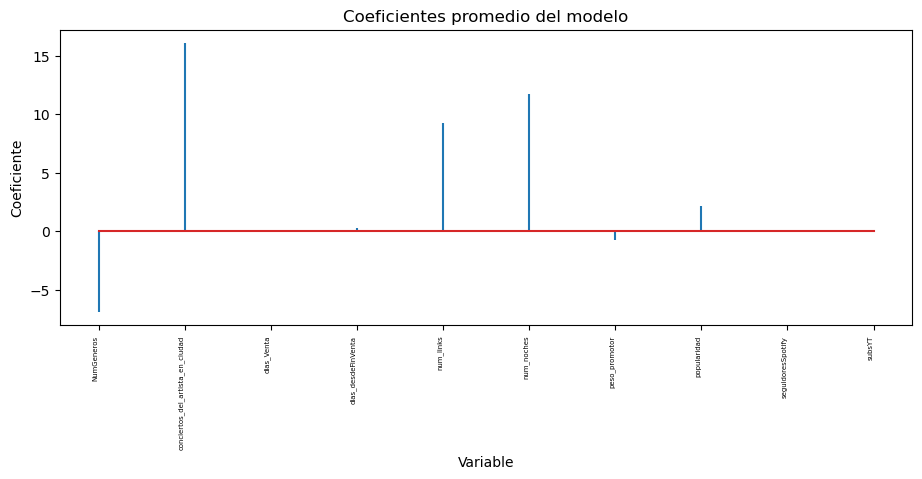

In [15]:
import pandas as pd
from sklearn.model_selection import cross_validate, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

# Tiempo de inicio de la ejecución
start_time = time.time()

# Definir el modelo
modelo = LinearRegression()

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_validate(modelo, X_numericas, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Obtener los resultados de la validación cruzada para cada iteración
train_mape_scores = -scores['train_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
train_mse_scores = -scores['train_mse']
train_rmse_scores = -scores['train_rmse']

test_mape_scores = -scores['test_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
test_mse_scores = -scores['test_mse']
test_rmse_scores = -scores['test_rmse']

# Imprimir los resultados para cada iteración
print("MAPE scores por iteración (entrenamiento):", train_mape_scores)
print("MAPE scores por iteración (validación):", test_mape_scores)

print("\nMSE scores por iteración (entrenamiento):", train_mse_scores)
print("MSE scores por iteración (validación):", test_mse_scores)

print("\nRMSE scores por iteración (entrenamiento):", train_rmse_scores)
print("RMSE scores por iteración (validación):", test_rmse_scores)

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_mape_scores)
train_mse_mean = np.mean(train_mse_scores)
train_rmse_mean = np.mean(train_rmse_scores)

test_mape_mean = np.mean(test_mape_scores)
test_mse_mean = np.mean(test_mse_scores)
test_rmse_mean = np.mean(test_rmse_scores)

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

# Obtener los coeficientes del modelo entrenado en cada iteración
all_coefs = [pd.DataFrame({'predictor': X_numericas.columns, 'coef': est.coef_}) for est in scores['estimator']]

# Calcular los coeficientes promedio
average_coefs = pd.concat(all_coefs).groupby('predictor')['coef'].mean()

# Crear la gráfica de barras para los coeficientes promedio
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(average_coefs.index, average_coefs.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes promedio del modelo')
plt.show()

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base sin escalar solo variables numéricas', scores, execution_time)


| **Iteración/Promedio** | **MAPE (Entrenamiento)** | **MAPE (Validación)** | **MSE (Entrenamiento)** | **MSE (Validación)** | **RMSE (Entrenamiento)** | **RMSE (Validación)** |
|------------------------|--------------------------|-----------------------|-------------------------|----------------------|--------------------------|-----------------------|
| 1                | 1.22033252               | 0.97746531            | 11766.17546096          | 2762.10542019        | 108.47200312             | 52.55573632           |
| 2                | 1.05187199               | 1.46052905            | 9896.29296494           | 8813.79803266        | 99.48011341              | 93.88183015           |
| 3                | 0.73460681               | 0.56171579            | 3547.75240108           | 33782.90150825       | 59.56301202              | 183.80125546          |
| 4                | 1.03565082               | 1.44930299            | 8832.30033771           | 31302.73355025       | 93.98031888              | 176.92578543          |
| **Promedio**      | **1.0106155353705215**     | **1.1122532818358555**  | **8510.63029117326**   | **19165.384627837222** | **90.37386186033069**  | **126.79115184046364**|


**Tiempo de ejecución**: 0.026071786880493164 segundos

Solo utilizando las variables numéricas, el error promedio en la validación es de 127€ que, aunque aún así es un error elevado, pero mejora en unos 30€ con respecto al modelo utilizando todo el conjunto de datos.

Después de estudiar el entrenamiento solo con una parte de las filas y, por otro lado, solo con una parte de las columnas, creemos que tiene más sentido estudiar solo una parte de las filas que una parte de las columnas, por lo que seguiremos con el conjunto de datos reducido a conciertos con precio máximo <= 100€.

Para ello, vamos a tener que volver un paso atrás, eliminar las filas que no queremos, realizar la estratificación de nuevo y corregir los valores de la columna "fold". El resultado lo encontramos en el conjunto de datos "maxEstratificado100.parquet", que es el usaremos a partir de ahora:

## RE-LECTURA Y RE-PREPROCESAMIENTO DE DATOS (SOBREESCRITURA)

In [16]:
import pandas as pd
datos= pd.read_parquet('maxEstratificado2.parquet')
datos

,name,EventStartTime,SalesStartTIme,SalesEndTime,max_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.00,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.00,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
2,Abba The New Experience & Queen Forever,2024-05-29 18:00:00+00:00,2024-02-28 14:00:00+00:00,2024-05-29 18:00:00+00:00,20.00,Abba The New Experience,Zona Camping Circuit Catalunya,Montmeló,Barcelona,0,...,0,0,0,0,0,0,91,0,1,0
3,Abraham Mateo y Nil Moliner,2024-08-16 20:00:00+00:00,2024-01-18 11:00:00+00:00,2024-08-14 21:59:00+00:00,57.14,Abraham Mateo,Auditorio Starlite,Marbella,Málaga,9,...,0,0,0,0,1,1,209,1,1,0
4,Abraham Mateo y Nil Moliner,2024-04-18 19:00:00+00:00,2023-11-16 11:00:00+00:00,2024-02-21 13:45:00+00:00,58.93,Abraham Mateo,Auditorio Starlite,Marbella,Málaga,9,...,0,0,0,0,1,1,97,57,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,40.00,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,0,1,0,0,0,176,0,1,3
409,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.00,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,0,102,0,1,3
410,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.00,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,0,291,0,1,3
411,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,75.00,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,0,266,0,1,3


In [17]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados']

datos.drop(columnas, axis=1, inplace=True)

columnas_a_escalar = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']

X = datos.drop(columns=['max_price', 'fold'])
y = datos['max_price']

## MODELO BASE ESCALANDO

#### --- Comprobación del escalado ---

Primero, haremos el escalado general de todos los datos aquí para comprobar que los datos se están escalando correctamente:

In [18]:
from sklearn.preprocessing import StandardScaler

# Inicializa el scaler
scaler = StandardScaler()

# Escala solo las columnas seleccionadas
X_scaled_subset = X.copy()  # Copia de X
X_scaled_subset[columnas_a_escalar] = scaler.fit_transform(X_scaled_subset[columnas_a_escalar])

# Mostrar las estadísticas descriptivas antes del escalado
print("Estadísticas descriptivas antes del escalado:")
print(X.describe())

# Mostrar las estadísticas descriptivas después del escalado
print("\nEstadísticas descriptivas después del escalado:")
print(X_scaled_subset.describe())

Estadísticas descriptivas antes del escalado:
        num_links  seguidoresSpotify  popularidad        subsYT  VenueClass  \
count  413.000000       4.130000e+02   413.000000  4.130000e+02  413.000000   
mean     4.387409       2.758691e+06    57.947357  1.353919e+06    0.530266   
std      3.887375       2.435122e+06    11.169708  1.165840e+06    0.813824   
min      0.000000       1.940000e+02     0.000000  6.670000e+02    0.000000   
25%      0.000000       2.760930e+05    57.000000  2.520000e+05    0.000000   
50%      5.000000       3.903875e+06    60.904615  1.716398e+06    0.000000   
75%      8.000000       4.564084e+06    60.904615  1.716398e+06    1.000000   
max     10.000000       1.428030e+07    85.000000  1.120000e+07    3.000000   

       NumGeneros  peso_promotor  tiene_lastfm_url  \
count  413.000000     413.000000        413.000000   
mean     2.055690      35.615012          0.145278   
std      1.542063      31.191072          0.352809   
min      1.000000       1.

In [19]:
X_scaled_subset

,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,tiene_twitter,...,Rock,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches
0,-0.872444,0.742297,0.265078,0.311294,2,-0.685426,-0.437033,0,1.580758,0,...,1,0,0,0,0,0,0,-0.995451,-0.118088,-0.20292
1,-0.872444,0.742297,0.265078,0.311294,2,-0.685426,-0.437033,0,1.580758,0,...,1,0,0,0,0,0,0,-0.995451,-0.118088,-0.20292
2,-1.129999,0.742297,0.265078,0.311294,1,-0.685426,-1.079020,0,-0.465803,0,...,1,0,0,0,0,0,0,-0.933251,-0.118088,-0.20292
3,1.187996,0.742297,0.265078,0.311294,0,-0.685426,0.943239,1,1.580758,1,...,0,0,0,0,0,1,1,0.290016,-0.053577,-0.20292
4,1.187996,0.742297,0.265078,0.311294,0,-0.685426,0.943239,1,1.580758,1,...,0,0,0,0,0,1,1,-0.871051,3.559055,-0.20292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,-1.129999,0.742297,0.265078,0.311294,0,-0.685426,-1.046920,0,-0.465803,0,...,0,0,0,1,0,0,0,-0.052084,-0.118088,-0.20292
409,-0.872444,0.742297,0.265078,0.311294,0,-0.685426,-0.886424,0,-0.465803,0,...,1,0,0,0,0,0,0,-0.819218,-0.118088,-0.20292
410,-1.129999,0.742297,0.265078,0.311294,0,-0.685426,-1.079020,0,-0.465803,0,...,1,0,0,0,0,0,0,1.140082,-0.118088,-0.20292
411,-1.129999,0.742297,0.265078,0.311294,1,-0.685426,-1.079020,0,-0.465803,0,...,1,0,0,0,0,0,0,0.880915,-0.118088,-0.20292


A la vista de los resultados, parece que los datos se están escalando correctamente ya que después del escalado:

- la media de todas las columnas es cercana a cero y
- la desviación estándar es cercana a uno,
- los rangos de los valores escalados son similares para todas las columnas y
- la forma general de la distribución de los datos no ha cambiado.

#### --- Comprobación del escalado ---

Probemos a hacer una primera aproximación del modelo base estandarizado con StandardScaler():

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inicializar el escalador y el modelo
scaler = StandardScaler()
model = LinearRegression()

results = []

# Listas para almacenar los resultados de cada iteración
train_scores = {'mape': [], 'mse': [], 'rmse': []}
test_scores = {'mape': [], 'mse': [], 'rmse': []}

# Realizar la validación cruzada manual
for fold in range(4):  # Iterar sobre los 4 pliegues

    print(f'\nFOLD {fold}')
    # Filtrar los datos para el pliegue actual
    X_train = X[datos['fold'] != fold]  # Todas las filas excepto las del pliegue actual
    X_test = X[datos['fold'] == fold]   # Solo las filas del pliegue actual
    y_train = y[datos['fold'] != fold]
    y_test = y[datos['fold'] == fold]

    # Seleccionar solo las columnas que deseas escalar
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Escalar los datos de entrenamiento
    X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train_scaled[columnas_a_escalar])

    # Aplicar la misma transformación a los datos de prueba
    X_test_scaled[columnas_a_escalar] = scaler.transform(X_test_scaled[columnas_a_escalar])

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calcular métricas de rendimiento en el conjunto de entrenamiento
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calcular métricas de rendimiento en el conjunto de prueba
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print("MAPE scores por iteración (entrenamiento):", train_mape)
    print("MAPE scores por iteración (validación):", test_mape)

    print("\nMSE scores por iteración (entrenamiento):", train_mse)
    print("MSE scores por iteración (validación):", test_mse)

    print("\nRMSE scores por iteración (entrenamiento):", train_rmse)
    print("RMSE scores por iteración (validación):", test_rmse)

    # Guardar los resultados de la iteración
    train_scores['mape'].append(train_mape)
    train_scores['mse'].append(train_mse)
    train_scores['rmse'].append(train_rmse)
    test_scores['mape'].append(test_mape)
    test_scores['mse'].append(test_mse)
    test_scores['rmse'].append(test_rmse)

    results.append({
        'Test Fold': fold,
        'MAPE Train': train_mape,
        'RMSE Train': train_rmse,
        'MSE Train': train_mse,
        'MAPE Val': test_mape,
        'RMSE Val': test_rmse,
        'MSE Val': test_mse
    })


# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_scores['mape'])
train_mse_mean = np.mean(train_scores['mse'])
train_rmse_mean = np.mean(train_scores['rmse'])

test_mape_mean = np.mean(test_scores['mape'])
test_mse_mean = np.mean(test_scores['mse'])
test_rmse_mean = np.mean(test_scores['rmse'])

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

results_df = pd.DataFrame(results)

# Calcular el promedio de las métricas y agregar al DataFrame
averages = results_df.mean(axis=0).to_dict()
averages['Test Fold'] = 'Promedio'
averages_df = pd.DataFrame([averages])

# Concatenar los resultados con los promedios
results_df = pd.concat([results_df, averages_df], ignore_index=True)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base bucle manual escalado estandar', results_df, execution_time)



FOLD 0
MAPE scores por iteración (entrenamiento): 0.23363121648612803
MAPE scores por iteración (validación): 56649100194.834915

MSE scores por iteración (entrenamiento): 128.90986628472805
MSE scores por iteración (validación): 2.9661963778665946e+26

RMSE scores por iteración (entrenamiento): 11.353848082686682
RMSE scores por iteración (validación): 17222648977049.363

FOLD 1
MAPE scores por iteración (entrenamiento): 0.24237318417120604
MAPE scores por iteración (validación): 0.4568099179707401

MSE scores por iteración (entrenamiento): 150.682621215659
MSE scores por iteración (validación): 265.0664430698269

RMSE scores por iteración (entrenamiento): 12.27528497492661
RMSE scores por iteración (validación): 16.28086125086222

FOLD 2
MAPE scores por iteración (entrenamiento): 0.24053483725510388
MAPE scores por iteración (validación): 2774720436.7125983

MSE scores por iteración (entrenamiento): 142.76087569798284
MSE scores por iteración (validación): 5.283330119279925e+22

RMS

**Iteración/Promedio** | **MAPE (Entrenamiento)** | **MAPE (Validación)** | **MSE (Entrenamiento)** | **MSE (Validación)** | **RMSE (Entrenamiento)** | **RMSE (Validación)** |
|----------------------|--------------------------|-----------------------|-------------------------|----------------------|--------------------------|-----------------------|
| 1          | 0.2305094634750004       | 150993368930.99902   | 128.72021236537677     | 1.3016576196272935e+27 | 11.34549304196943      | 36078492479970.58    |
| 2          | 0.24237318417120585      | 0.4568099179707398   | 150.68262121565903     | 265.0664430698264   | 12.275284974926612     | 16.280861250862202   |
| 3          | 0.24051758576466672      | 1636109155.78603     | 142.75693294008943     | 1.832396376307792e+22 | 11.948093276338675     | 135366036224.29787   |
| 4          | 0.25176677840113554      | 0.4722148915171281   | 158.14784569149228     | 330.21146567134974  | 12.575684700702872     | 18.171721593491075   |
| **Promedio** | **0.24129175295300215** | **38157369521.92853** | **145.07690305315438** | **3.2541898589776415e+26** | **12.036138998484397** | **9053464629057.332** |



Los resultados son sospechosamente elevados haciendo la validación cruzada a mano con un bucle (estamos hablando de 13 cifras). Vamos a probar a hacer alguna transformación a ver si logramos alguna mejora.

En primer lugar, vamos a probar a hacer un escalado robusto. El StandardScaler es más apropiado cuando las características están normalmente distribuidas y los valores atípicos no son un problema importante, mientras que el RobustScaler es más adecuado cuando se necesite una escala resistente a los valores atípicos o cuando la distribución de las características es muy sesgada.

Aquí hay una comparación entre el **RobustScaler** y el StandardScaler:

- StandardScaler:

    - Estandariza las características eliminando la media y escalando a la varianza unitaria. Calcula la media y la desviación estándar de cada característica y luego escala cada característica restando la media y dividiendo por la desviación estándar.
    - Es sensible a los valores atípicos, ya que la media y la desviación estándar pueden verse afectadas por valores extremos.
    - Es más apropiado cuando las características se distribuyen normalmente o aproximadamente normalmente, y cuando los valores atípicos no son comunes o no son problemáticos.

- RobustScaler:

    - Escala las características utilizando estadísticas robustas para evitar verse afectado por valores atípicos. Utiliza la mediana y el rango intercuartil (IQR) en lugar de la media y la desviación estándar.
    - Es menos sensible a los valores atípicos en comparación con el StandardScaler.
    - Es más adecuado cuando los datos contienen valores atípicos o cuando la distribución de las características es muy sesgada o no normal.

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inicializar el escalador y el modelo
scaler = RobustScaler()
model = LinearRegression()

results = []

# Listas para almacenar los resultados de cada iteración
train_scores = {'mape': [], 'mse': [], 'rmse': []}
test_scores = {'mape': [], 'mse': [], 'rmse': []}

# Realizar la validación cruzada manual
for fold in range(4):  # Iterar sobre los 4 pliegues

    print(f'\nFOLD {fold}')
    # Filtrar los datos para el pliegue actual
    X_train = X[datos['fold'] != fold]  # Todas las filas excepto las del pliegue actual
    X_test = X[datos['fold'] == fold]   # Solo las filas del pliegue actual
    y_train = y[datos['fold'] != fold]
    y_test = y[datos['fold'] == fold]

    # Seleccionar solo las columnas que deseas escalar
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Escalar los datos de entrenamiento
    X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train_scaled[columnas_a_escalar])

    # Aplicar la misma transformación a los datos de prueba
    X_test_scaled[columnas_a_escalar] = scaler.transform(X_test_scaled[columnas_a_escalar])

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calcular métricas de rendimiento en el conjunto de entrenamiento
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calcular métricas de rendimiento en el conjunto de prueba
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print("MAPE scores por iteración (entrenamiento):", train_mape)
    print("MAPE scores por iteración (validación):", test_mape)

    print("\nMSE scores por iteración (entrenamiento):", train_mse)
    print("MSE scores por iteración (validación):", test_mse)

    print("\nRMSE scores por iteración (entrenamiento):", train_rmse)
    print("RMSE scores por iteración (validación):", test_rmse)

    # Guardar los resultados de la iteración
    train_scores['mape'].append(train_mape)
    train_scores['mse'].append(train_mse)
    train_scores['rmse'].append(train_rmse)
    test_scores['mape'].append(test_mape)
    test_scores['mse'].append(test_mse)
    test_scores['rmse'].append(test_rmse)

    results.append({
        'Test Fold': fold,
        'MAPE Train': train_mape,
        'RMSE Train': train_rmse,
        'MSE Train': train_mse,
        'MAPE Val': test_mape,
        'RMSE Val': test_rmse,
        'MSE Val': test_mse
    })

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_scores['mape'])
train_mse_mean = np.mean(train_scores['mse'])
train_rmse_mean = np.mean(train_scores['rmse'])

test_mape_mean = np.mean(test_scores['mape'])
test_mse_mean = np.mean(test_scores['mse'])
test_rmse_mean = np.mean(test_scores['rmse'])

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

results_df = pd.DataFrame(results)

# Calcular el promedio de las métricas y agregar al DataFrame
averages = results_df.mean(axis=0).to_dict()
averages['Test Fold'] = 'Promedio'
averages_df = pd.DataFrame([averages])

# Concatenar los resultados con los promedios
results_df = pd.concat([results_df, averages_df], ignore_index=True)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base bucle manual escalado robusto', results_df, execution_time)


FOLD 0
MAPE scores por iteración (entrenamiento): 0.23069731302209953
MAPE scores por iteración (validación): 0.509605679532727

MSE scores por iteración (entrenamiento): 128.66406806565072
MSE scores por iteración (validación): 540.3993381791176

RMSE scores por iteración (entrenamiento): 11.343018472419532
RMSE scores por iteración (validación): 23.24649087882121

FOLD 1
MAPE scores por iteración (entrenamiento): 0.24237318417120668
MAPE scores por iteración (validación): 0.4568099179707411

MSE scores por iteración (entrenamiento): 150.682621215659
MSE scores por iteración (validación): 265.0664430698279

RMSE scores por iteración (entrenamiento): 12.27528497492661
RMSE scores por iteración (validación): 16.28086125086225

FOLD 2
MAPE scores por iteración (entrenamiento): 0.2405056515577954
MAPE scores por iteración (validación): 0.3496156367838949

MSE scores por iteración (entrenamiento): 142.75676457917612
MSE scores por iteración (validación): 325.0837266751384

RMSE scores por

| **Iteración/Promedio**   | **MAPE (Entrenamiento)** | **MAPE (Validación)** | **MSE (Entrenamiento)** | **MSE (Validación)** | **RMSE (Entrenamiento)** | **RMSE (Validación)** |
|--------------------------|--------------------------|-----------------------|-------------------------|----------------------|--------------------------|-----------------------|
| 1          | 0.23069731302209945      | 0.5096056795327265   | 128.66406806565072     | 540.3993381791144   | 11.343018472419532     | 23.246490878821138   |
| 2          | 0.24237318417120654      | 0.4568099179707404   | 150.682621215659       | 265.066443069828    | 12.27528497492661      | 16.28086125086225    |
| 3          | 0.2405056515577958       | 0.34961563678389407  | 142.75676457917612     | 325.08372667513675  | 11.948086230822748     | 18.030078387936552   |
| 4          | 0.2517667784011357       | 0.47221489151712753  | 158.14784569149228     | 330.21146567134974  | 12.575684700702872     | 18.171721593491075   |
| **Promedio**   | **0.24133573178805937**  | **0.44706153145112215**  | **145.06282488799454**     | **365.1902433988572**   | **12.03551859471794**      | **18.932288027777755**   |


Vemos que han mejorado (y mucho) los errores gracias a este pequeño cambio. Aun así, vamos a tratar de hacer alguna mejora a ver si es posible.

Si lo comparamos con el error del modelo base sin escalar solo para entradas < 100€:
> 18.672122998571112 vs 18.932288027777755

Sigue siendo mejor el modelo base sin escalar aunque la diferencia es ínfima.
Cabe decir que, sin el filtrado de entradas menores que 100€, la diferencia entre ambos modelo (sin escalado y con escalado) era abismal, como se refleja en la tabla "Comparación de Promedios para ambos tipos del modelo base" de a continuación.

> #### Comparación de Promedios para ambos tipos del modelo base sin el filtrado de entradas a 100€ o menos
>
> | Métrica        | Promedio (Sin Escalar)  | Promedio (Escalando) |
> |----------------|-------------------------|----------------------|
> | MAPE (train)   | 0.7758                  | 0.7804               |
> | MAPE (val)     | 1.3479                  | 6.811e+11            |
> |----------------|-------------------------|----------------------|
> | MSE (train)    | 5139.2512               | 5148.4636            |
> | MSE (val)      | 29676.2480              | 8.558e+28            |
> |----------------|-------------------------|----------------------|
> | RMSE (train)   | 70.3316                 | 70.3879              |
> | RMSE (val)     | 159.8569                | 1.662e+14            |
>
> Aunque los errores en el entrenamiento son similares, vemos que el modelo escalado no es capaz de generalizar bien lo aprendido con datos que no ha visto.

Entre las mejoras que mencionamos que vamos a tratar de hacer, vamos a intentar introducir los conceptos ColumnTransformer y Pipeline (una simplificación del código anterior).

En cada iteración de cross validate se hará el fit_transform del escalado con los datos de entrenamiento para aplicarlo (transform) después a los datos de test. Para lograrlo, se crea un objeto Pipeline que permite encadenar el escalado y después el modelo.

In [22]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), columnas_a_escalar)  # Escalar solo las columnas numéricas
    ], remainder='passthrough')  # Pasar las demás columnas sin cambios

# Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_val_score(pipeline, X, y, cv=ps, scoring='neg_root_mean_squared_error')

print("RMSE Scores:", -scores)
print("Average RMSE:", -np.mean(scores))

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base escalado robust column transformer', scores, execution_time)

RMSE Scores: [23.24649088 16.28086125 18.03007839 18.17172159]
Average RMSE: 18.9322880277778


Si comparmamos el RMSE entre el escalado robusto sin pipeline y con pipeline:

> 18.932288027777755 vs 18.932288027777773

Observamos que el error de estos 2 últimos códigos es el mismo.

Por seguir la misma estela que el modelo base sin escalar, vamos a probar a hacer el modelo base escalando sobre las variables numéricas y usando solo éstas para la predicción (digamos que eliminamos las variables categóricas/ binarias para esta parte):

In [23]:
X_numericas = X[columnas_a_escalar]
X_numericas

,num_links,seguidoresSpotify,popularidad,subsYT,NumGeneros,peso_promotor,conciertos_del_artista_en_ciudad,dias_Venta,dias_desdeFinVenta,num_noches
0,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
1,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
2,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,91,0,1
3,9,4.564084e+06,60.904615,1.716398e+06,1,65,2.0,209,1,1
4,9,4.564084e+06,60.904615,1.716398e+06,1,65,2.0,97,57,1
...,...,...,...,...,...,...,...,...,...,...
408,0,4.564084e+06,60.904615,1.716398e+06,1,3,1.0,176,0,1
409,1,4.564084e+06,60.904615,1.716398e+06,1,8,1.0,102,0,1
410,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,291,0,1
411,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,266,0,1


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

# Definir el pipeline con la estandarización y el modelo de regresión lineal
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Escalador para estandarizar las características
    ('regressor', LinearRegression())  # Modelo de regresión lineal
])

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_val_score(pipeline, X_numericas, y, cv=ps, scoring='neg_mean_squared_error')

# Convertir las puntuaciones a RMSE (raíz del error cuadrático medio)
rmse_scores = np.sqrt(-scores)

# Calcular el RMSE promedio
avg_rmse = np.mean(rmse_scores)

# Imprimir los resultados
print("RMSE Scores:", rmse_scores)
print("Average RMSE:", avg_rmse)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo base escalado robutso solo variables numéricas', scores, execution_time)

RMSE Scores: [24.25682626 21.1420431  21.28041857 20.56156533]
Average RMSE: 21.810213313842638


El error promedio ha empeorado:

> 18.932288027777773 vs 21.81021331384265

Este último código era un intento de estrategia para ver si el modelo mejoraba o, al menos, se mantenía, lo que, en tal caso, hubiera dado lugar a una selección de variables. Es decir, por el principio de parsimonia, nos hubiésemos quedado únicamente con estas variables porque explican la mayor parte del modelo (pues entre las 58 variables y solo estas 9, el error sería el mismo). Sin embargo, no es el caso así que esta estrategia no ha sido exitosa.

----------------------------
#### ¡¡ Parte eliminada del proyecto por inutilidad !!
Ahora utilizaremos las funciones de búsqueda para buscar la mejor combinación de valores entre los distintos hiperparámetros del modelo.

## CON PARÁMETROS Y GRIDSEARCH

La búsqueda en rejilla (grid search) es exhaustiva:
- Prueba todas las combinaciones posibles de hiperparámetros en la
cuadrícula definida
- Requiere definir los valores a evaluar para cada hiperparámetro
- En los parámetros continuos se puede poner el rango a explorar y el
incremento entre dos valores consecutivos
- Encuentra la mejor combinación de todas las evaluadas
- Pero puede dejar regiones interesantes sin explorar bien
- Escala muy mal si consideramos muchos hiperparámetros con muchos
valores a explorar

In [2]:
"""import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'fit_intercept': [True, False],
}

# Tiempo de inicio de la ejecución
start_time = time.time()

# Crear el objeto GridSearchCV con return_train_score=True
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(grid_search.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"Pliegue {i + 1}:")
    print("MSE (test):")
    print(-cv_results[f"split{i}_test_neg_mean_squared_error"])
    print("RMSE (test):")
    print(-cv_results[f"split{i}_test_neg_root_mean_squared_error"])
    print("MAPE (test):")
    print(-cv_results[f"split{i}_test_mape"])
    print("MSE (train):")
    print(-cv_results[f"split{i}_train_neg_mean_squared_error"])
    print("RMSE (train):")
    print(-cv_results[f"split{i}_train_neg_root_mean_squared_error"])
    print("MAPE (train):")
    print(-cv_results[f"split{i}_train_mape"])

# Identificar el mejor parámetro para cada split
best_params_per_split = {}
for split in range(4):
    split_results = cv_results[cv_results[f'split{split}_test_neg_mean_squared_error'] == cv_results[f'split{split}_test_neg_mean_squared_error'].min()]
    best_params_per_split[split] = split_results['param_fit_intercept'].iloc[0]
    print(f"Mejor parámetro para el pliegue {split + 1}: {best_params_per_split[split]}")

# Calcular las métricas promedio de train
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error']
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error']
mean_mape_train = -cv_results['mean_train_mape']

# Calcular las métricas promedio de val
mean_mse = -cv_results['mean_test_neg_mean_squared_error']
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error']
mean_mape = -cv_results['mean_test_mape']

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (train):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo gridSearch', cv_results, execution_time)"""

'import pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import PredefinedSplit, GridSearchCV\nfrom sklearn.metrics import mean_absolute_percentage_error, make_scorer\nimport time\n\n# Definir la función para el cálculo del MAPE\ndef mape_scorer(y_true, y_pred):\n    return mean_absolute_percentage_error(y_true, y_pred)\n\n# Definir los scorers\nscoring = {\n    \'neg_mean_squared_error\': \'neg_mean_squared_error\',  # MSE\n    \'neg_root_mean_squared_error\': \'neg_root_mean_squared_error\',  # RMSE\n    \'mape\': make_scorer(mape_scorer, greater_is_better=False)  # MAPE\n}\n\n# Definir el array test_fold a partir de la columna \'folds\'\ntest_fold = datos[\'fold\'].values\n\n# Crear el PredefinedSplit\nps = PredefinedSplit(test_fold=test_fold)\n\n# Definir los parámetros a buscar\nparam_grid = {\n    \'fit_intercept\': [True, False],\n}\n\n# Tiempo de inicio de la ejecución\nstart_time = time.time()\n\n# Crear el objeto GridSearchCV con r

## CON PARÁMETROS Y RANDOMSEARCH

La búsqueda aleatoria (random search) explora combinaciones de hiperparámetros de manera aleatoria dentro de un rango predefinido para cada hiperparámetro durante un número fijo de iteraciones:
- Elige la mejor combinación según la métrica de evaluación
- Puede encontrar una buena combinación de hiperparámetros en menos tiempo y con menos exploraciones
    - O puede que no
- El resultado puede variar de una ejecución a otra debido a la aleatoriedad inherente al método

In [1]:
"""import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'fit_intercept': [True, False],
}

# Inicializar el modelo de regresión lineal
base_model = LinearRegression()

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(random_search.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"Pliegue {i + 1}:")
    print("MSE (test):")
    print(-cv_results[f"split{i}_test_neg_mean_squared_error"])
    print("RMSE (test):")
    print(-cv_results[f"split{i}_test_neg_root_mean_squared_error"])
    print("MAPE (test):")
    print(-cv_results[f"split{i}_test_mape"])
    print("MSE (train):")
    print(-cv_results[f"split{i}_train_neg_mean_squared_error"])
    print("RMSE (train):")
    print(-cv_results[f"split{i}_train_neg_root_mean_squared_error"])
    print("MAPE (train):")
    print(-cv_results[f"split{i}_train_mape"])

# Identificar el mejor parámetro para cada split
best_params_per_split = {}
for split in range(4):
    split_results = cv_results[cv_results[f'split{split}_test_neg_mean_squared_error'] == cv_results[f'split{split}_test_neg_mean_squared_error'].min()]
    best_params_per_split[split] = split_results['param_fit_intercept'].iloc[0]
    print(f"Mejor parámetro para el pliegue {split + 1}: {best_params_per_split[split]}")

# Calcular las métricas promedio de train
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error']
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error']
mean_mape_train = -cv_results['mean_train_mape']

# Calcular las métricas promedio de val
mean_mse = -cv_results['mean_test_neg_mean_squared_error']
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error']
mean_mape = -cv_results['mean_test_mape']

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (train):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Modelo randomSearch', cv_results, execution_time)"""

'import pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import PredefinedSplit, RandomizedSearchCV\nfrom sklearn.metrics import mean_absolute_percentage_error, make_scorer\nimport numpy as np\nimport time\n\n# Definir la función para el cálculo del MAPE\ndef mape_scorer(y_true, y_pred):\n    return mean_absolute_percentage_error(y_true, y_pred)\n\n# Definir los scorers\nscoring = {\n    \'neg_mean_squared_error\': \'neg_mean_squared_error\',  # MSE\n    \'neg_root_mean_squared_error\': \'neg_root_mean_squared_error\',  # RMSE\n    \'mape\': make_scorer(mape_scorer, greater_is_better=False)  # MAPE\n}\n\n# Definir el array test_fold a partir de la columna \'folds\'\ntest_fold = datos[\'fold\'].values\n\n# Crear el PredefinedSplit\nps = PredefinedSplit(test_fold=test_fold)\n\n# Definir los parámetros a buscar\nparam_grid = {\n    \'fit_intercept\': [True, False],\n}\n\n# Inicializar el modelo de regresión lineal\nbase_model = LinearRegression

### Comparando los resultados de Grid y Random Search
de las métricas promedio obtenidas en la validación y solo para el mejor parámetro fit_intercept = True:


|  | Promedio Grid | Promedio Random |
| --- | ---------- | --------------- |
| MAPE | 0.447 | 0.447 |
| MSE | 365.190 | 365.190 |
| RMSE | 18.932 | 18.932 |


> Solo para la validación y fit_intercept=True

En este caso, como tampoco hay muchos hiperparámetros y valores de ellos con los que probar, podemos ver que no varían en absoluto los resultados entre una búsqueda y otra.

#### Hasta aquí, la fase de "búsquedas" ha sido muteada
---------------------------

## REGULARIZACIÓN

Para este apartado, podemos hacer:

- Emplear RidgeCV, LassoCV o ElasticNetCV.

- Combinar GridSearchCV y un modelo de tipo Ridge, Lasso o ElasticNet.

En un principio, estábamos haciendo la implementación con la primera opción, pero con ella no era posible obtener todas las métricas deseadas de cada iteración de la validación cruzada (el parámetro store_cv_results especificado en la documentación no funcionaba).

Por ello, emplearemos mejor la segunda opción, cuya implementación será igual o muy similar a la del apartado anterior.

### Ridge

In [27]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'alpha': np.logspace(-5, 7, 200),
    'fit_intercept': [True],
}

# Inicializar el modelo de regresión lineal
ridge = Ridge()

# Crear el objeto GridSearchCV
ridgecv = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
ridgecv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(ridgecv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", ridgecv.best_params_['alpha'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[ridgecv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[ridgecv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[ridgecv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[ridgecv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Regularización ridge sin escalar', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 4.659525668664678
MSE (test): 431.3875262997916
RMSE (test): 20.76987063753146
MAPE (test): 0.42972053178657327
MSE (train): 168.58036082175536
RMSE (train): 12.983849999971325
MAPE (train): 0.2895471621972774

Pliegue 2:
Mejor valor de alpha: 4.659525668664678
MSE (test): 255.20367302183428
RMSE (test): 15.975095399459569
MAPE (test): 0.4436582812898832
MSE (train): 189.36941273780346
RMSE (train): 13.761155937558568
MAPE (train): 0.3006298611469888

Pliegue 3:
Mejor valor de alpha: 4.659525668664678
MSE (test): 317.2828323136137
RMSE (test): 17.81243476657848
MAPE (test): 0.348871635858082
MSE (train): 182.44079689408463
RMSE (train): 13.507064703113132
MAPE (train): 0.2962572220214681

Pliegue 4:
Mejor valor de alpha: 4.659525668664678
MSE (test): 315.31921219841115
RMSE (test): 17.75722985711485
MAPE (test): 0.4367006425560898
MSE (train): 183.2239261461767
RMSE (train): 13.536023276656135
MAPE (train): 0.2920758010788805

Métricas promedio:
MSE pr

|   Iteración    | Mejor valor de alpha | MSE (train) | MSE (val)  | RMSE (train) | RMSE (val)  | MAPE (train)  | MAPE (val)  |
|----------------|----------------------|-------------|------------|--------------|-------------|---------------|-------------|
| 1              | 4.660                | 168.580     | 431.388    | 12.984       | 20.770      | 0.290         | 0.430       |
| 2              | 4.660                | 189.369     | 255.204    | 13.761       | 15.975      | 0.301         | 0.444       |
| 3              | 4.660                | 182.441     | 317.283    | 13.507       | 17.812      | 0.296         | 0.349       |
| 4              | 4.660                | 183.224     | 315.319    | 13.536       | 17.757      | 0.292         | 0.437       |
| **Promedio**   | **4.660**            | **180.903** | **329.798**| **13.447**   | **18.079**  | **0.295**     | **0.415**   |

**Tiempo de ejecución**: 5.291637182235718 segundos


Y si calculamos los coeficientes de las variables para el mejor modelo:

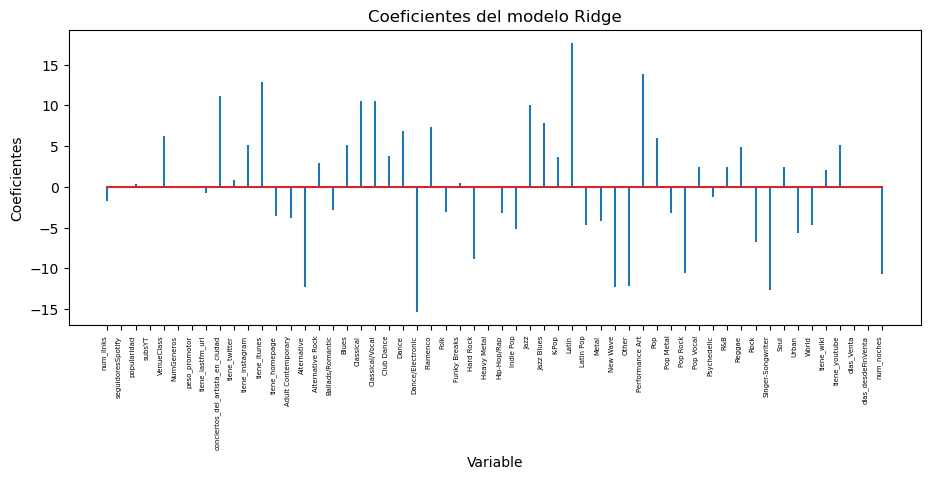

In [28]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': ridgecv.best_estimator_.coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Ridge')
plt.show()


Pero si escalamos con Robust Scaler...

In [29]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'ridge__alpha': np.logspace(-5, 7, 200),
    'ridge__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo de regresión lineal
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Crear el objeto GridSearchCV
ridgecv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
ridgecv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(ridgecv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", ridgecv.best_params_['ridge__alpha'])
    print("MSE (val):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (val):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (val):", -cv_results[f"split{i}_test_mape"].iloc[ridgecv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[ridgecv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[ridgecv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[ridgecv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Regularización ridge robust scaler', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 5.3535666774107185
MSE (val): 429.4592726698387
RMSE (val): 20.72339915819407
MAPE (val): 0.43101846167754015
MSE (train): 173.24628068112474
RMSE (train): 13.16230529508888
MAPE (train): 0.2931561330069337

Pliegue 2:
Mejor valor de alpha: 5.3535666774107185
MSE (val): 257.7227818152502
RMSE (val): 16.053746659744267
MAPE (val): 0.44517353680113364
MSE (train): 194.55452627964536
RMSE (train): 13.948280405829435
MAPE (train): 0.3051807798953653

Pliegue 3:
Mejor valor de alpha: 5.3535666774107185
MSE (val): 320.408271243441
RMSE (val): 17.899951710645507
MAPE (val): 0.3465550906509578
MSE (train): 187.62389071628724
RMSE (train): 13.697587039923755
MAPE (train): 0.29980500725939213

Pliegue 4:
Mejor valor de alpha: 5.3535666774107185
MSE (val): 315.59533067945387
RMSE (val): 17.765002974372223
MAPE (val): 0.43971435221942795
MSE (train): 187.45488273390637
RMSE (train): 13.691416388887834
MAPE (train): 0.295771696162627

Métricas promedio:
MSE promedi

|                | Mejor valor de alpha | MSE (train) | MSE (val) | RMSE (train) | RMSE (val) | MAPE (train) | MAPE (val) |
|----------------|-----------------------|-------------|-----------|--------------|------------|---------------|------------|
| Iteración 1    | 5.354                 | 173.246     | 429.459   | 13.162       | 20.723     | 0.293         | 0.431      |
| Iteración 2    | 5.354                 | 194.555     | 257.723   | 13.948       | 16.054     | 0.305         | 0.445      |
| Iteración 3    | 5.354                 | 187.624     | 320.408   | 13.698       | 17.900     | 0.300         | 0.347      |
| Iteración 4    | 5.354                 | 187.455     | 315.595   | 13.691       | 17.765     | 0.296         | 0.440      |
| **Promedio**   | **5.354**             | **185.720** | **330.796** | **13.625**  | **18.111** | **0.298**    | **0.416**  |

**Tiempo de ejecución**: 12.514724493026733 segundos


Y entonces los coeficientes de ajuste del modelo se verían afectados:

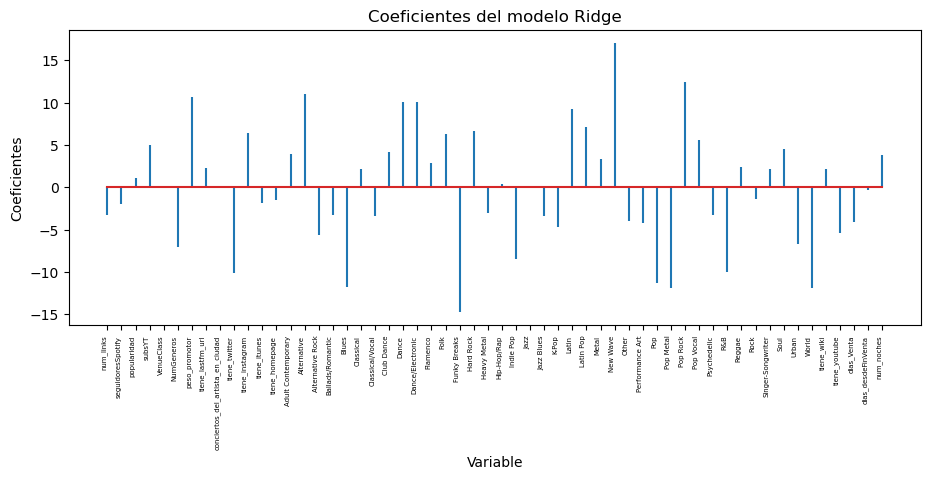

In [30]:
# Coeficientes del modelo Ridge
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': ridgecv.best_estimator_.named_steps['ridge'].coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Ridge')
plt.show()

Aunque en este caso, el modelo Ridge sin escalar dé ligeramente mejor que escalando, hay que tener en cuenta que, **en regularización**, se emplee un método u otro, **siempre hay que estandarizar o normalizar los predictores**. Por eso mismo, Lasso y Elastic Net lo haremos directamente escalando con Robust Scaler.

### Lasso

In [31]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'lasso__alpha': np.logspace(-10, 3, 200),
    'lasso__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo Lasso
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
])

# Crear el objeto GridSearchCV
lassocv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
lassocv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(lassocv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", lassocv.best_params_['lasso__alpha'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[lassocv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[lassocv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[lassocv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[lassocv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[lassocv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[lassocv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[lassocv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[lassocv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[lassocv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[lassocv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[lassocv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[lassocv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Regularización laso mejor alpha', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 0.023004301197729216
MSE (test): 503.2294405954274
RMSE (test): 22.4327760340852
MAPE (test): 0.4897403158710769
MSE (train): 132.11313311519783
RMSE (train): 11.494047725461984
MAPE (train): 0.24414174580658102

Pliegue 2:
Mejor valor de alpha: 0.023004301197729216
MSE (test): 256.2423479399551
RMSE (test): 16.0075715815971
MAPE (test): 0.4382692625773183
MSE (train): 153.6261622677823
RMSE (train): 12.39460214237562
MAPE (train): 0.2505798354209382

Pliegue 3:
Mejor valor de alpha: 0.023004301197729216
MSE (test): 334.5294389869252
RMSE (test): 18.290145953133486
MAPE (test): 0.3457584026541515
MSE (train): 146.4475654101344
RMSE (train): 12.101552190117365
MAPE (train): 0.24893313686481144

Pliegue 4:
Mejor valor de alpha: 0.023004301197729216
MSE (test): 328.3309610786058
RMSE (test): 18.119905106777072
MAPE (test): 0.46483617114538195
MSE (train): 160.76004809225353
RMSE (train): 12.67911858499058
MAPE (train): 0.25873045944872014

Métricas promed

|                | Mejor valor de alpha | MSE (train) | MSE (test) | RMSE (train) | RMSE (test) | MAPE (train) | MAPE (test) |
|----------------|-----------------------|-------------|------------|--------------|-------------|---------------|-------------|
| Iteración 1    | 0.023                 | 132.113     | 503.229    | 11.494       | 22.433      | 0.244         | 0.490       |
| Iteración 2    | 0.023                 | 153.626     | 256.242    | 12.395       | 16.008      | 0.251         | 0.438       |
| Iteración 3    | 0.023                 | 146.448     | 334.529    | 12.102       | 18.290      | 0.249         | 0.346       |
| Iteración 4    | 0.023                 | 160.760     | 328.331    | 12.679       | 18.120      | 0.259         | 0.465       |
| **Promedio**   | **0.023**            | **148.237**  | **355.583** | **12.167**  | **18.713**  | **0.251**    | **0.435**    |

**Tiempo de ejecución**: 15.410528659820557 segundos


#### Una rápida comparación para no olvidar de dónde venimos:

- Primer código sin escalar:

    - MSE promedio (train): 8976.44591100815  ,  MSE promedio (val): 13537.868069633174
    - RMSE promedio (train): 93.07653935768221  ,  RMSE promedio (val): 103.77492141090286
    - MAPE promedio (train): 0.9024508234696331  ,  MAPE promedio (val): 0.9321956035577382
    - Mejor valor de alpha: 2.833

- Escalando con StandardScaler():
    - MSE promedio (train): 8078.719160407341  ,  MSE promedio (val): 13509.271689609533
    - RMSE promedio (train): 88.51222489281574  ,  RMSE promedio (val): 105.97913274991129
    - MAPE promedio (train): 0.8119053729969078  ,  MAPE promedio (val): 0.8497987034052792

- Escalando con RobustScaler():
    - MSE promedio (train): 11702.402362097351  ,  MSE promedio (val): 13106.41220970984
    - RMSE promedio (train): 105.93099488768578  ,  RMSE promedio (val): 101.290698372672
    - MAPE promedio (train): 1.2352519828581694  ,  MAPE promedio (val): 1.3194801097670736
    - Mejor valor de alpha: 49.37047852839004

- Escalando el nuevo conjunto filtrado con RobustScaler() (código actual):
    - MSE promedio (train): 148.23672722134202  ,  MSE promedio (val): 355.583047150228
    - RMSE promedio (train): 12.167330160736388  ,  RMSE promedio (val): 18.712599668898203
    - MAPE promedio (train): 0.25059629438526276  ,  MAPE promedio (val): 0.434651038061982
    - Mejor valor de alpha: 0.023004301197729216

Y si calculamos los coeficientes que mejor se ajustan al modelo:

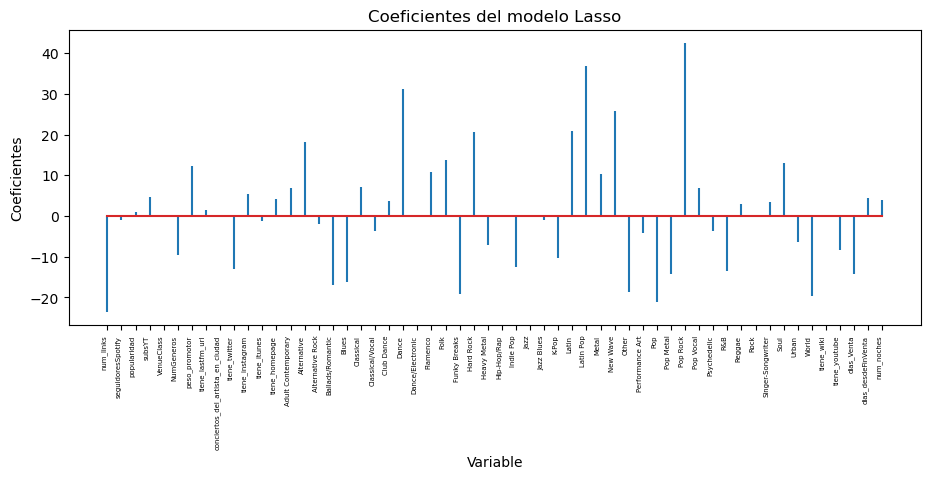

In [32]:
# Coeficientes del modelo
lasso_coef = lassocv.best_estimator_.named_steps['lasso'].coef_
predictor_names = X.columns

df_coeficientes = pd.DataFrame({
    'predictor': predictor_names,
    'coef': lasso_coef
})

# Plot de los coeficientes
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Lasso')
plt.show()


### Elastic Net

Nota: El siguiente código tarda en ejecutarse 4 minutos y medio.

In [33]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'elastic_net__alpha': np.logspace(-10, 3, 200),
    'elastic_net__l1_ratio': [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    'elastic_net__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo ElasticNet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet())
])

# Crear el objeto GridSearchCV
elastic_net_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
elastic_net_cv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(elastic_net_cv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", elastic_net_cv.best_params_['elastic_net__alpha'])
    print("Mejor valor de l1_ratio:", elastic_net_cv.best_params_['elastic_net__l1_ratio'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[elastic_net_cv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[elastic_net_cv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[elastic_net_cv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[elastic_net_cv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MAX_PRICE', 'Regularización elastic mejor alpha y lambda', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 0.01702769172225905
Mejor valor de l1_ratio: 0
MSE (test): 429.5056236996789
RMSE (test): 20.72451745396449
MAPE (test): 0.43085941301844777
MSE (train): 172.76454268419147
RMSE (train): 13.143992646231641
MAPE (train): 0.29263883186908096

Pliegue 2:
Mejor valor de alpha: 0.01702769172225905
Mejor valor de l1_ratio: 0
MSE (test): 257.6049456029476
RMSE (test): 16.050076186826892
MAPE (test): 0.4449568107475011
MSE (train): 194.09823266416424
RMSE (train): 13.931914178036134
MAPE (train): 0.3047226406239656

Pliegue 3:
Mejor valor de alpha: 0.01702769172225905
Mejor valor de l1_ratio: 0
MSE (test): 320.52984736055885
RMSE (test): 17.903347378648466
MAPE (test): 0.3466354690203782
MSE (train): 187.19302397015684
RMSE (train): 13.681850166193051
MAPE (train): 0.2993720876081126

Pliegue 4:
Mejor valor de alpha: 0.01702769172225905
Mejor valor de l1_ratio: 0
MSE (test): 315.6008221675863
RMSE (test): 17.765157532867146
MAPE (test): 0.43975445028471166
MSE

|                | Mejor valor de alpha | Mejor valor de l1_ratio | MSE (train) | MSE (val)  | RMSE (train) | RMSE (val)  | MAPE (train)  | MAPE (val)  |
|----------------|----------------------|-------------------------|-------------|------------|--------------|-------------|---------------|-------------|
| Pliegue 1      | 0.017                | 0                       | 172.765     | 429.506    | 13.144       | 20.725      | 0.293         | 0.431       |
| Pliegue 2      | 0.017                | 0                       | 194.098     | 257.605    | 13.932       | 16.050      | 0.305         | 0.445       |
| Pliegue 3      | 0.017                | 0                       | 187.193     | 320.530    | 13.682       | 17.903      | 0.299         | 0.347       |
| Pliegue 4      | 0.017                | 0                       | 187.115     | 315.601    | 13.679       | 17.765      | 0.295         | 0.440       |
| **Promedio**   | **0.017**            | **0**                   | **184.793** | **330.811**| **13.609**   | **18.111**  | **0.298**     | **0.416**   |

**Tiempo de ejecución**: 270.12095379829407 segundos


#### Una rápida comparación también en Elastic Net para no olvidar de dónde venimos:

- Primer código sin escalar
    - MSE promedio (train): 8746.52598648442  ,  MSE promedio (val): 11765.620568170532
    - RMSE promedio (train): 91.58195013108454  ,  RMSE promedio (val): 94.68668888974095
    - MAPE promedio (train): 0.8272284351528056  ,  MAPE promedio (train): 0.8632637148016473
    - Mejor valor de alpha: 0.9884959046625587

- Escalando con Standard Scaler
    - MSE promedio (train): 7818.437830794652  ,  MSE promedio (val): 11319.165310476836
    - RMSE promedio (train): 86.56011602747081  ,  RMSE promedio (val): 94.09859258446278
    - MAPE promedio (train): 0.7053219182804643  ,  MAPE promedio (train): 0.8110594172268102
    - Mejor valor de alpha: 1.552225357427048

- Escalando con Robust Scaler
    - MSE promedio (train): 9561.50074060167  ,  MSE promedio (val): 11904.975745323149
    - RMSE promedio (train): 95.68786712177179  ,  RMSE promedio (val): 95.65897018468034
    - MAPE promedio (train): 0.9772530271731139  ,  MAPE promedio (train): 1.0600144799720241
    - Mejor valor de alpha: 2.0970464013232393

- Escalando el nuevo conjunto filtrado con RobustScaler() (código actual):
    - MSE promedio (train): 185.29258937097728  ,  MSE promedio (val): 330.810309707693
    - RMSE promedio (train): 13.609184835423939  ,  RMSE promedio (val): 18.11077463807675
    - MAPE promedio (train): 0.2980201573950807  ,  MAPE promedio (val): 0.41555153576776044

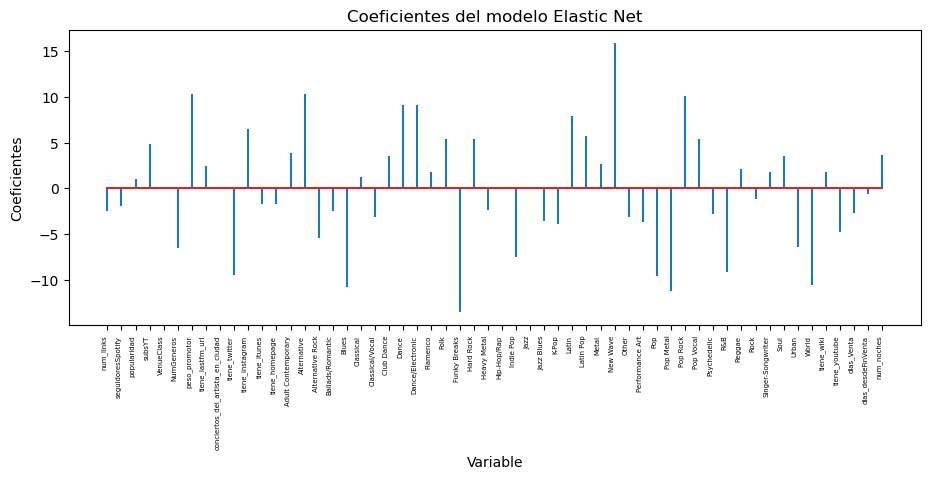

In [34]:
# Coeficientes del modelo ElasticNet
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': elastic_net_cv.best_estimator_.named_steps['elastic_net'].coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Elastic Net')
plt.show()


--------------------------

-------------------

## RESULTADOS FINALES

Comparando todos los modelos implementados en este script para *regresión lineal*:

|                     | Modelo base sin escalar | Modelo base con filtrado | Modelo base solo numérico | Modelo base escalado SS | Modelo base escalado RS | Modelo base escalado CT | Modelo base escalado num | GridSearchCV | RandomizedSearchCV | Ridge sin escalar | Ridge escalado RS | Lasso escalado RS | Elastic Net escalado RS |
|---------------------|--------------------------|---------------------------|---------------------------|-------------------------|-------------------------|--------------------------|---------------------------|--------------|--------------------|-------------------|-------------------|-------------------|--------------------------|
| MAPE promedio (val)| 1.3479                   | 0.4526                    | 1.1123                    | 3.8157e+10             | 0.4471                  | -                        | -                         | 0.4352       | 0.4352             | 0.4147            | 0.4156            | 0.4347            | 0.4156                   |
| MSE promedio (val) | 29676.2480               | 355.7347                  | 19165.3846                | 3.2542e+26                | 365.1902                | -                        | -                         | 363.1973     | 363.1973           | 329.7983          | 330.7964          | 355.583          | 330.8103                 |
| RMSE promedio (val)| 159.8569                 | 18.6721                   | 126.7912                  | 9.0535e+12                     | 18.9323                 | 18.9323                  | 21.8102                   | 18.8413      | 18.8413            | 18.0787           | 18.1105           | 18.7126           | 18.1108                  |
| Tiempo de ejecución| 0.0677 s                 | 0.0777 s                  | 0.0261 s                  | 0.0655 s                  | 0.0782 s                   | 0.0573 s                        | 0.0702 s                       | 0.1427 s     | 0.2342 s           | 5.2916 s          | 12.5147 s         | 15.4105 s         | 270.121 s                |
| Mejor valor de alpha| -                       | -                         | -                         | -                       | -                       | -                        | -                         | -            | -                  | 4.6595            | 5.3536            | 0.0230            | 0.0170                   |
| Mejor valor de l1_ratio| -                     | -                         | -                         | -                       | -                       | -                        | -                         | -            | -                  | -                 | -                 | -                 | 0                        |

Siendo:

1) Modelo base sin escalar
2) Modelo base sin escalar con filtrado de precios <= 100€
3) Modelo base sin escalar solo con variables numéricas

--

4) Modelo base escalando con StandardScaler()
5) Modelo base escalando con RobustScaler()
6) Modelo base escalando con RobustScaler() y en pipeline usando ColumnTransformer()
7) Modelo base escalando con RobustScaler() solo con las variables numéricas

--

8) Búsqueda en rejilla GridSearch
9) Búsqueda aleatoria RandomizedSearch

--

10) Regularización Ridge sin escalar
11) Regularización Ridge escalando con RobustScaler()
12) Regularización Lasso escalando con RobustScaler()
13) Regularización Elastic Net escalando con RobustScaler()

Para determinar el mejor modelo, debemos considerar varias métricas, como MAPE, MSE y RMSE en el conjunto de validación, así como el tiempo de ejecución y los mejores valores de los hiperparámetros.

En este caso, el mejor modelo podría ser el "Ridge sin escalar" o el "Ridge escalado RS". Estos modelos tienen valores similares en MAPE, MSE y RMSE en el conjunto de validación, lo que indica una buena capacidad de generalización. Además, tienen tiempos de ejecución relativamente bajos en comparación con el modelo "Elastic Net escalado RS", lo que sugiere una eficiencia computacional mejorada.

Ambos modelos utilizan la regularización Ridge, lo que puede ayudar a prevenir el sobreajuste y mejorar la estabilidad del modelo. Sin embargo, la diferencia en los tiempos de ejecución entre los dos modelos no es significativa, por lo que la elección final entre ellos podría depender de otros factores, como la interpretabilidad del modelo o la disponibilidad de recursos computacionales.

------------------------

## ANÁLISIS POR SEGMENTOS (VENUE CLASS) PARA EL MEJOR MODELO

In [35]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Definir el modelo Ridge con el mejor alpha
ridge = Ridge(alpha=4.659525668664678, fit_intercept=True)

# Entrenar el modelo
ridge.fit(X, y)

# Generar predicciones
y_pred = ridge.predict(X)

# Añadir las predicciones al DataFrame original
datos['pred'] = y_pred

# Crear una lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos['VenueClass'].unique():
    subset = datos[datos['VenueClass'] == vc]
    mse = mean_squared_error(subset['max_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['max_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)

# Imprimir los resultados
print("\nResultados por 'VenueClass':")
print(resultados)



Resultados por 'VenueClass':
   VenueClass         mse       rmse      mape
0           2  246.838217  15.711086  0.282925
1           1  318.650716  17.850790  0.334458
2           0  147.605172  12.149287  0.303203
3           3   32.662684   5.715128  0.066261


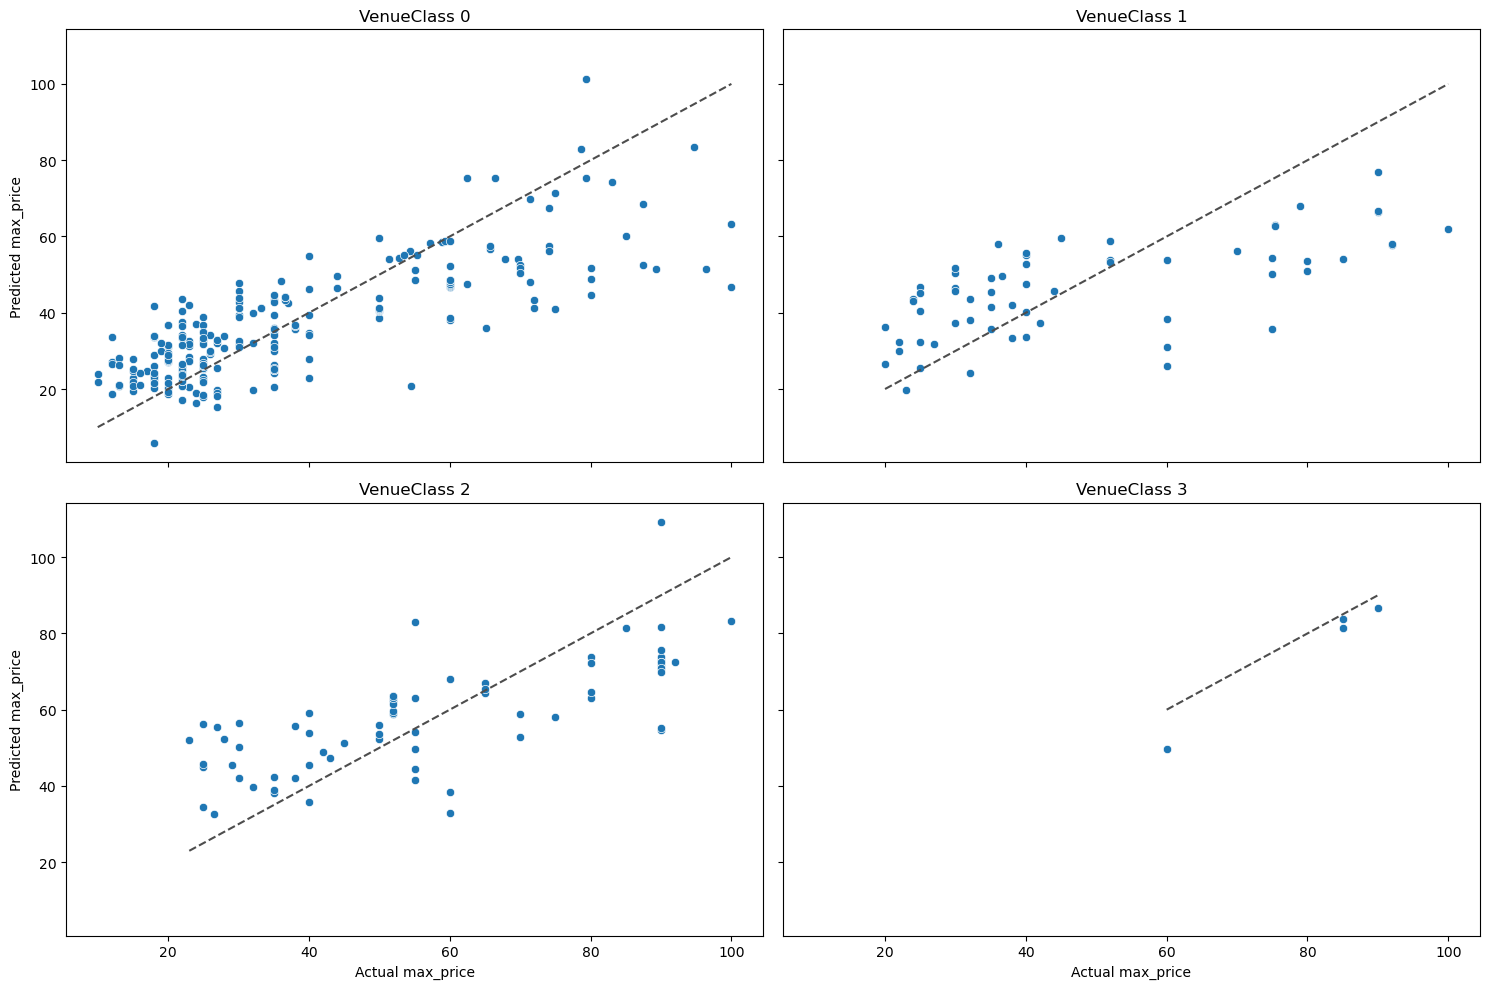

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de dispersión para comparar predicciones con valores reales por cada "VenueClass"
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Asegurarnos de que los valores de 'VenueClass' están ordenados para una mejor visualización
venue_classes = sorted(datos['VenueClass'].unique())

for idx, vc in enumerate(venue_classes):
    subset = datos[datos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['max_price'], y=subset['pred'])
    ax.plot([subset['max_price'].min(), subset['max_price'].max()],
            [subset['max_price'].min(), subset['max_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual max_price')
    ax.set_ylabel('Predicted max_price')

plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Definir el modelo Ridge con el mejor alpha
ridge = Ridge(alpha=4.659525668664678, fit_intercept=True)

# Entrenar el modelo
ridge.fit(X, y)

# Generar predicciones
y_pred = ridge.predict(X)

# Añadir las predicciones al DataFrame original
datos['pred'] = y_pred

# Crear una lista para almacenar los resultados
resultados_list = []

# Mostrar ejemplos de los datos particionados por "VenueClass"
print(datos[['VenueClass', 'max_price', 'pred']].groupby('VenueClass').head())

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos['VenueClass'].unique():
    subset = datos[datos['VenueClass'] == vc]
    print(f"\nAnalizando 'VenueClass' {vc}")
    print(subset[['max_price', 'pred']].head())  # Mostrar los primeros ejemplos

    mse = mean_squared_error(subset['max_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['max_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)

# Imprimir los resultados
print("\nResultados por 'VenueClass':")
print(resultados)


     VenueClass  max_price       pred
0             2      28.00  52.383142
1             2      50.00  52.383142
2             1      20.00  36.363808
3             0      57.14  58.370536
4             0      58.93  58.457972
5             3      90.00  86.734761
6             0      60.00  38.170928
7             0      60.00  38.644452
8             0      75.00  41.107226
10            2      55.00  82.925933
13            3      60.00  49.735286
14            1      60.00  38.350260
15            1      30.00  46.606942
20            2      85.00  81.438068
21            1      24.00  43.687390
22            1      25.00  46.736885
26            2      25.00  34.406714
68            3      85.00  83.689177
280           3      85.00  81.407461

Analizando 'VenueClass' 2
    max_price       pred
0        28.0  52.383142
1        50.0  52.383142
10       55.0  82.925933
20       85.0  81.438068
26       25.0  34.406714

Analizando 'VenueClass' 1
    max_price       pred
2        20

Recordemos que 0=sala, 1=teatro, 2=estadio S y 3=estadio M.

El modelo parece funcionar mejor para VenueClass 3, seguido de VenueClass 0, 2 y 1 en ese orden.

Sin embargo, para la clase 3, tenemos muy pocos datos de muestra que al parecer ha conseguido predecir de una manera bastante precisa.

Para el resto de clases vemos que cuanto más aumenta el precio real, menos precisa es la predicción, de ahí que los errores sean mas altos en comparación con la clase 3.

La clase 0 es la que tiene una muestra de datos mayor, lo que podría ser positivo para que el sistema aprendiera bien, pero negativo porque hay más probabilidad de errores.

Los MAPEs calculados para cada VenueClass indican el porcentaje medio de error absoluto entre las predicciones del modelo y los valores reales del precio máximo, específicamente para cada clase de Venue.

El MAPE de la clase 3 es excelente por situarse debajo del 10%. El resto de MAPEs, por ejemplo, el de la clase 2 que es del 28.29%, significa que, en promedio, las predicciones del modelo para el precio máximo de los venues de esa clase tienen un error absoluto del 28.29% en relación con los valores reales.